<h1 style='color:purple' align='center'>Data Science Regression Project: Predicting Home Prices in Colombo</h1>

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

<h2 style='color:blue'>Data Load: Load banglore home prices into a dataframe</h2>

In [412]:
df1 = pd.read_csv("colombo_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Messenger Street Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Cross Street,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [413]:
df1.shape

(13428, 9)

In [414]:
df1.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [415]:
df1['area_type'].unique()

array(['Super built-up  Area', 'Plot  Area', 'Built-up  Area', nan,
       'Carpet  Area'], dtype=object)

In [416]:
df1['area_type'].value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

**Drop features that are not required to build our model**

In [417]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13428, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [418]:
df2.isnull().sum()

location       38
size          124
total_sqft    116
bath          180
price         216
dtype: int64

In [419]:
df2.shape

(13428, 5)

In [420]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [421]:
df3.shape

(13139, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [422]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

**Explore total_sqft feature**

In [0]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [424]:
2+3

5

# New Section

In [425]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
31,Keyzer Street,4 BHK,2100 - 2850,4.0,186.000,4
125,KOSWATTE,4 BHK,3067 - 8156,4.0,477.000,4
140,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
168,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
191,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
416,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
555,Aluthgama Road,2 BHK,1195 - 1440,2.0,63.770,2
654,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
667,Keyzer Street,2 BHK,1120 - 1145,2.0,48.130,2
678,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion. I am going to just drop such corner cases to keep things simple**

In [0]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [427]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Messenger Street Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2475 which is an average of the range 2100-2850**

In [428]:
df4.loc[30]

location      Messenger Street
size                     3 BHK
total_sqft                1025
bath                         2
price                       47
bhk                          3
Name: 30, dtype: object

In [429]:
(2100+2850)/2

2475.0

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [430]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Messenger Street Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Cross Street,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [431]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.309300e+04
mean     7.871782e+03
std      1.071602e+05
min      2.678298e+02
25%      4.258369e+03
50%      5.416667e+03
75%      7.250000e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [432]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

Wattala                533
Messenger Street       479
Grandpass Road         392
Quarry Road            289
New Air Port Road      264
                      ... 
Sulthangunta             1
Sector 3 HSR Layout      1
Kanakapura Road,         1
Gollarahatti             1
S R Layout               1
Name: location, Length: 1281, dtype: int64

In [433]:
location_stats.values.sum()

13093

In [434]:
len(location_stats[location_stats>100])

13

In [435]:
len(location_stats)

1281

In [436]:
len(location_stats[location_stats<=100])

1268

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [437]:
location_stats_less_than_10 = location_stats[location_stats<=100]
location_stats_less_than_10

John's Road                 98
Bellandur                   96
Hoodi                       88
KR Puram                    88
Electronics City Phase 1    87
                            ..
Sulthangunta                 1
Sector 3 HSR Layout          1
Kanakapura Road,             1
Gollarahatti                 1
S R Layout                   1
Name: location, Length: 1268, dtype: int64

In [438]:
len(df5.location.unique())

1281

In [439]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

14

In [440]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Messenger Street Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,other,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Cross Street,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,other,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,other,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Wattala,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,other,4 BHK,2732.0,4.0,204.00,4,7467.057101
9,Messenger Street,3 BHK,1310.0,3.0,63.25,3,4828.244275
10,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
11,Wattala,3 BHK,1800.0,2.0,70.00,3,3888.888889


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

**As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft**

In [441]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
10,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
46,other,8 Bedroom,600.0,9.0,200.0,8,33333.333333
59,other,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
69,other,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
71,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [442]:
df5.shape

(13093, 7)

In [443]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12355, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [444]:
df6.price_per_sqft.describe()

count     12355.000000
mean       6249.154804
std        4112.676254
min         267.829813
25%        4201.185164
50%        5274.725275
75%        6861.352880
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 12000000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [445]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10992, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

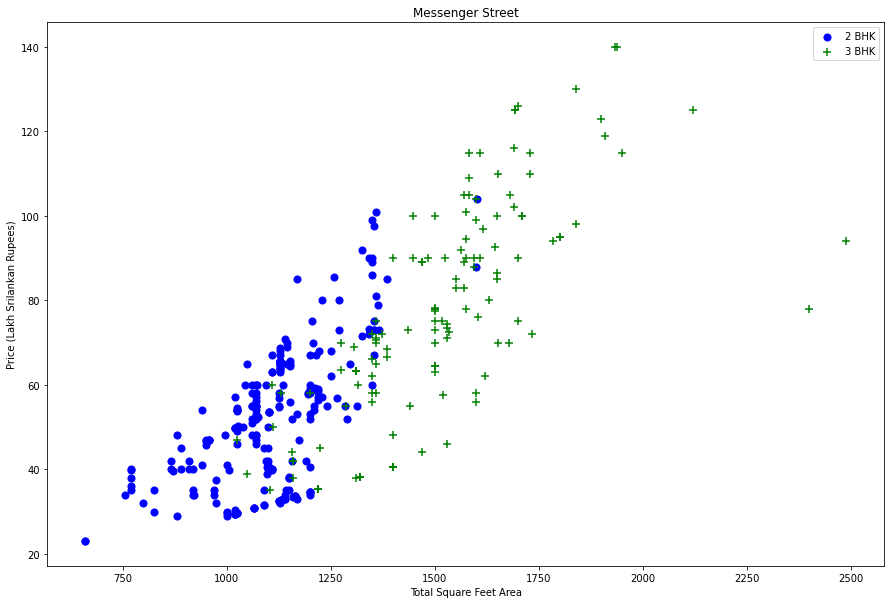

In [446]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Srilankan Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Messenger Street")

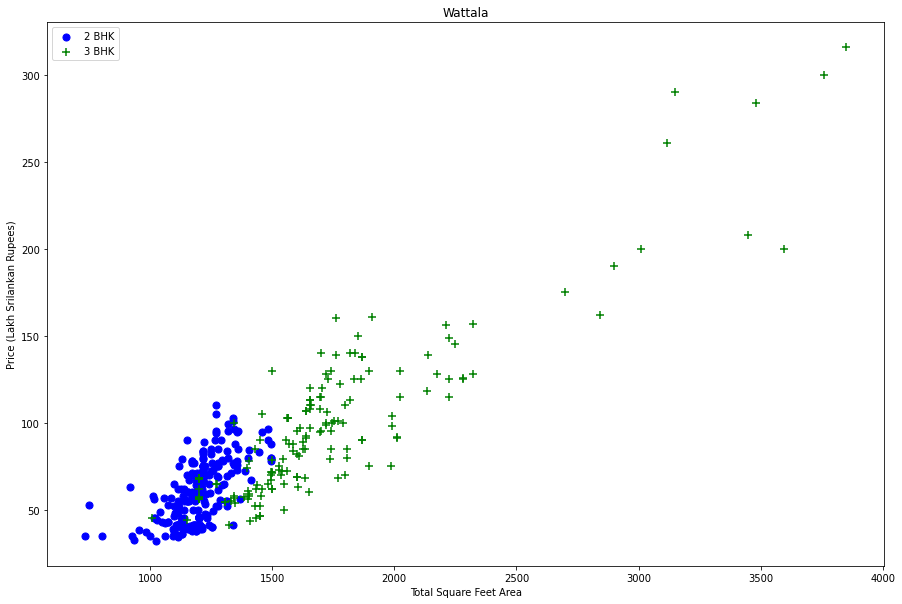

In [447]:
plot_scatter_chart(df7,"Wattala")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [448]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(6152, 7)

**Plot same scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

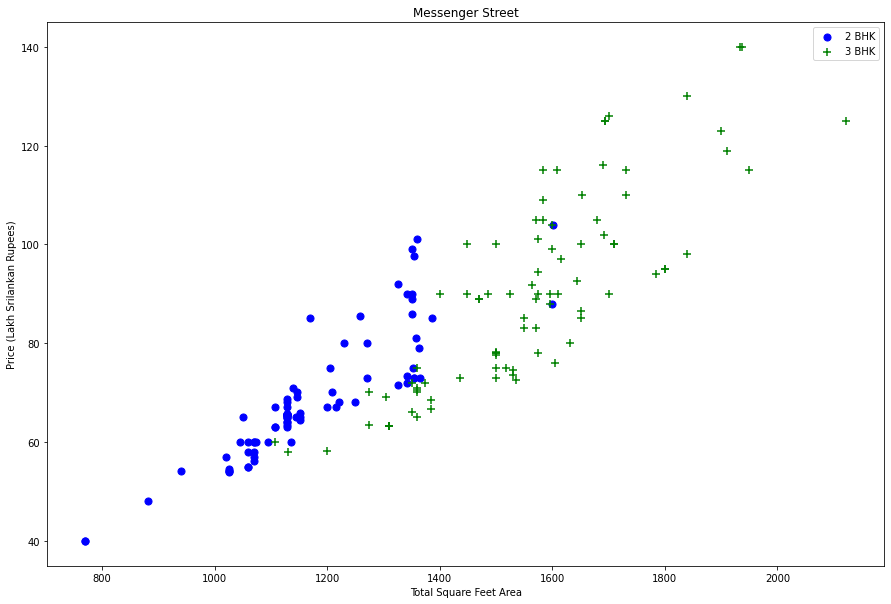

In [449]:
plot_scatter_chart(df8,"Messenger Street")

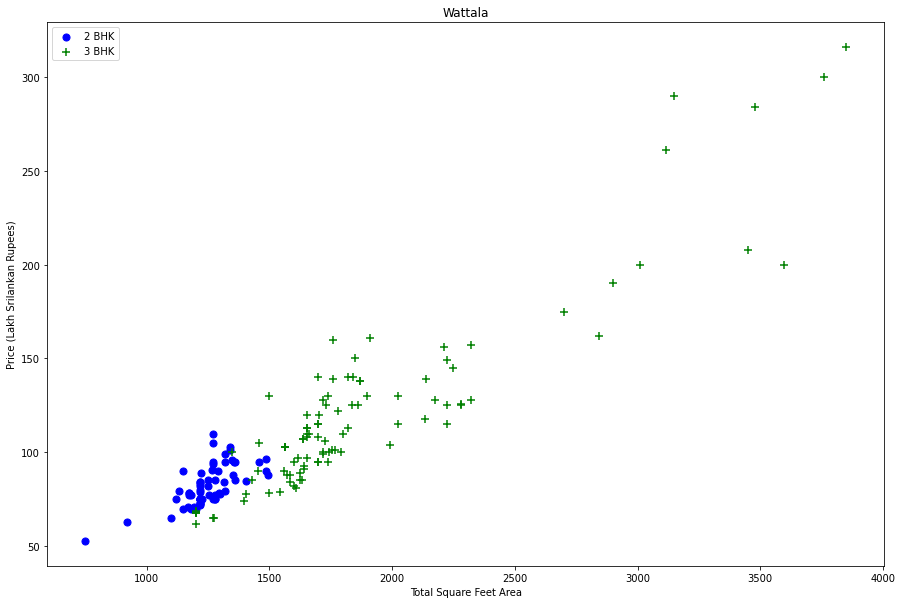

In [450]:
plot_scatter_chart(df8,"Wattala")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

<img src="rajaji_nagar_outliers.png"></img>

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

<img src="hebbal_outliers.png"></img>

Text(0, 0.5, 'Count')

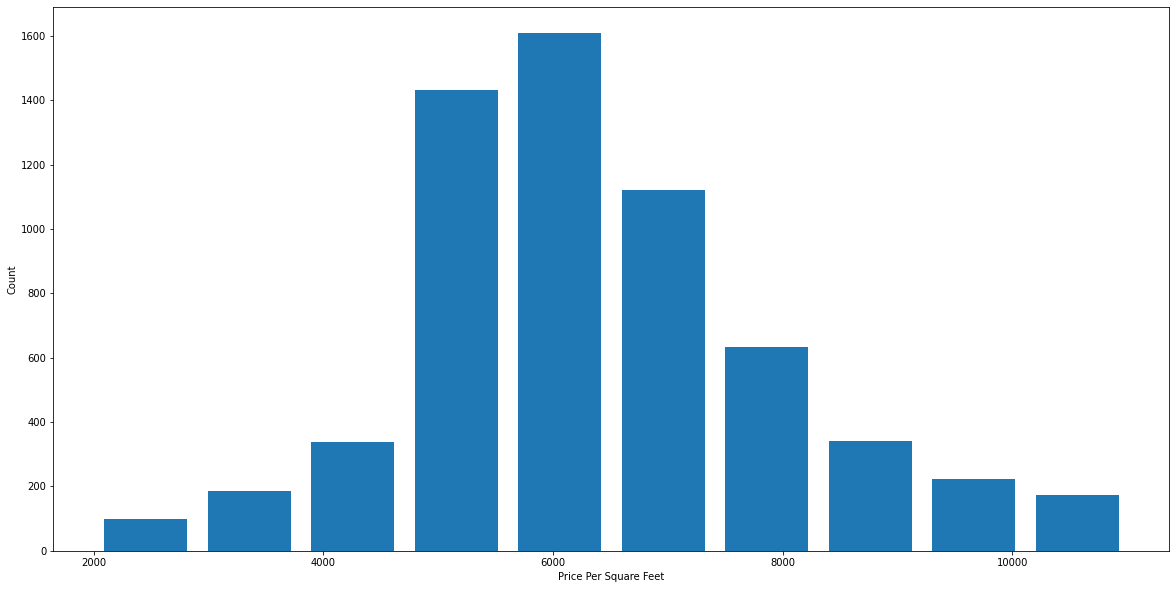

In [451]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [452]:
df8.bath.unique()

array([ 3.,  8.,  2.,  4.,  6.,  1.,  9.,  7.,  5., 12., 16., 13.])

Text(0, 0.5, 'Count')

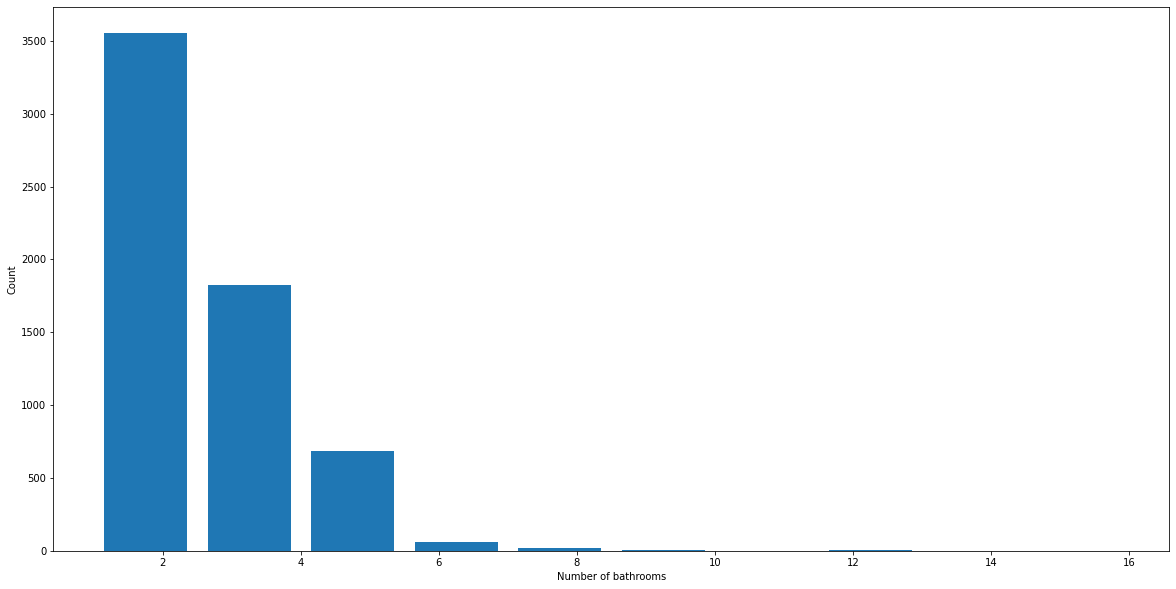

In [453]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [454]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
4765,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
5090,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
7707,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
8103,other,10 BHK,4000.0,12.0,160.0,10,4000.000000
8921,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [455]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
2804,Wolfendhal Street,3 BHK,1806.0,6.0,116.0,3,6423.034330
4463,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689
9778,other,4 Bedroom,7000.0,8.0,450.0,4,6428.571429


**Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed**

In [456]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(6085, 7)

In [457]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Aluthgama Road,3 BHK,2089.0,3.0,140.0,3,6701.771182
1,Aluthgama Road,8 Bedroom,5000.0,8.0,250.0,8,5000.000000


In [458]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,Aluthgama Road,2089.0,3.0,140.00,3
1,Aluthgama Road,5000.0,8.0,250.00,8
2,Aluthgama Road,1385.0,2.0,83.09,2


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [459]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,Aluthgama Road,CANAL ROAD,Cross Street,Grandpass Road,KOSWATTE,Keyzer Street,Messenger Street,Messenger Street Phase II,New Air Port Road,Quarry Road,Union Place,Wattala,Wolfendhal Street,other
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [460]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,Aluthgama Road,CANAL ROAD,Cross Street,Grandpass Road,KOSWATTE,Keyzer Street,Messenger Street,Messenger Street Phase II,New Air Port Road,Quarry Road,Union Place,Wattala,Wolfendhal Street
0,Aluthgama Road,2089.0,3.0,140.00,3,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Aluthgama Road,5000.0,8.0,250.00,8,1,0,0,0,0,0,0,0,0,0,0,0,0
2,Aluthgama Road,1385.0,2.0,83.09,2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Aluthgama Road,1317.5,2.0,63.77,2,1,0,0,0,0,0,0,0,0,0,0,0,0
5,Aluthgama Road,2264.0,3.0,159.00,3,1,0,0,0,0,0,0,0,0,0,0,0,0


In [461]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,Aluthgama Road,CANAL ROAD,Cross Street,Grandpass Road,KOSWATTE,Keyzer Street,Messenger Street,Messenger Street Phase II,New Air Port Road,Quarry Road,Union Place,Wattala,Wolfendhal Street
0,2089.0,3.0,140.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
1,5000.0,8.0,250.0,8,1,0,0,0,0,0,0,0,0,0,0,0,0


<h2 style='color:blue'>Build a Model Now...</h2>

In [462]:
df12.shape

(6085, 17)

In [463]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,Aluthgama Road,CANAL ROAD,Cross Street,Grandpass Road,KOSWATTE,Keyzer Street,Messenger Street,Messenger Street Phase II,New Air Port Road,Quarry Road,Union Place,Wattala,Wolfendhal Street
0,2089.0,3.0,3,1,0,0,0,0,0,0,0,0,0,0,0,0
1,5000.0,8.0,8,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1385.0,2.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0


In [464]:
X.shape

(6085, 16)

In [465]:
y = df12.price
y.head(3)

0    140.00
1    250.00
2     83.09
Name: price, dtype: float64

In [466]:
len(y)

6085

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [468]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8455931608223589

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [469]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.84275511, 0.87143323, 0.87494516, 0.87563494, 0.85528007])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [470]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.864010,{'normalize': False}
1,lasso,0.847845,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.835481,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [0]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [472]:
predict_price('Messenger Street',1000, 2, 2)

49.09744317226796

In [473]:
predict_price('Grandpass Road',1000, 3, 3)

61.990729974440356

In [474]:
predict_price('Grandpass Road',1000, 2, 2)

58.75667739110017

In [475]:
predict_price('Grandpass Road',1000, 3, 3)

61.990729974440356

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [0]:
import pickle
with open('colombo_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [0]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))